# Human Activity Recognition Using Smartphones
Statistical Learning Methods [223490-0286] - Summer semester 2019/20
- Author: Jakub Sypniewski
- Index number: 73030
- Tutor: Agata Skorupka

- Data source: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones


# 1) Introduction, problem description

Dataset was created by measuring activity of smartphone while subject was moving. <br>
Several people participated in this experiment. <br>
The task is to perform **classification** task. <br>
Target variable - activity label - 6 different activities are selected:
- WALKING
- WALKING_UPSTAIRS
- WALKING_DOWNSTAIRS
- SITTING
- STANDING
- LAYING
<br>

This dataset consists of 561 variables with non-missing observations. There are 7352 observations for each of the variables.
The proper explanation of variables is examined in attached files on the site, but just to mention: data was gathered by measuring activity of giroscope - velocities, accelerations etc. in 3 dimensions:
- X axis
- Y axis
- Z axis

Then a variety of additional preprocessing actions took place ending up with 561 features - we are dealing with **high dimensionality**. <br> 
Measured signal was collected with 50 Hz frequency - we are dealing here also with **time-series task**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Data is already splitted into Test and Train sets. <br>
For this task information about subject id is rather unnecessary.

I download new features.txt and name it features_correct.txt - this version does not have duplicates.

In [4]:
with open('features_correct.txt', 'r') as f:
    features_list = f.read().splitlines()

In [23]:
X_train = pd.read_csv('train/X_train.txt', header=None, names=features_list, sep='\s+')
y_train = pd.read_csv('train/y_train.txt', delimiter=' ', names=['label'], sep='\s+')

In [24]:
print('Train set shape: ', X_train.shape)
print('Train(label) set shape: ', y_train.shape)

Train set shape:  (7352, 561)
Train(label) set shape:  (7352, 1)


In [25]:
X_test = pd.read_csv('test/X_test.txt', sep='\s+', header=None, names=features_list)
y_test = pd.read_csv('test/y_test.txt', sep='\s+', names=['label'])
print('Test set shape: ', X_test.shape)
print('Test(label) set shape: ', y_test.shape)

Test set shape:  (2947, 561)
Test(label) set shape:  (2947, 1)


In [26]:
train_test_ratio =  (X_train.shape[0] / ( X_train.shape[0] +  X_test.shape[0])) * 100
print('{:.1f}% of the whole dataset was used as training set and the remaining part as test set'.format(train_test_ratio))

71.4% of the whole dataset was used as training set and the remaining part as test set


In [27]:
print('Number of duplicates in training file: ', sum(X_train.duplicated()))

Number of duplicates in training file:  0


In [28]:
print('Number of missing values in training file: ', X_train.isna().values.sum())

Number of missing values in training file:  0


In [29]:
with open('activity_labels.txt', 'r') as f:
    activity_labels = f.read().splitlines()

In [30]:
activity_labels

['1 WALKING',
 '2 WALKING_UPSTAIRS',
 '3 WALKING_DOWNSTAIRS',
 '4 SITTING',
 '5 STANDING',
 '6 LAYING']

In [31]:
y_train_label = pd.read_csv('activity_labels.txt', header=None, names=['activity'], delim_whitespace=True)

In [32]:
y_train_with_label = pd.merge(left=y_train, 
                              right=y_train_label, 
                              left_on='label', 
                              right_on=y_train_label.index, 
                              how='left')

# 2 & 3) Cleaning and preprocessing data & exploratory data analysis

Checking if there is any imbalance in activity (y_train):

In [33]:
y_train_with_label.groupby(['activity']).size().reset_index(name='counts')

,activity,counts
0,LAYING,1407
1,SITTING,1286
2,STANDING,1374
3,WALKING,1226
4,WALKING_DOWNSTAIRS,986
5,WALKING_UPSTAIRS,1073


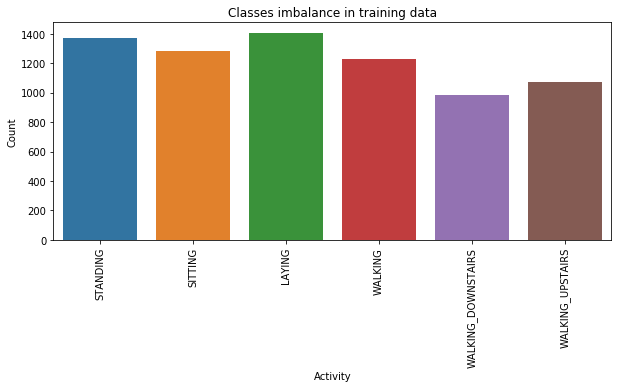

In [34]:
plt.figure(figsize=(10,4))
plt.title('Classes imbalance in training data')
sns.countplot(y_train_with_label['activity'])
plt.ylabel('Count')
plt.xlabel('Activity')
plt.xticks(rotation=90)
plt.show()

As we can see, data is slightly imbalanced. 

What we observe so far is that we have clean data - **no missing values / duplicates**. <br>
But there are two major problems:
<li> High dimensionality - 561 features </li>
<li> Slight classes imbalance </li>

In [36]:
subject_id_training = pd.read_csv('train/subject_train.txt', header=None, names=['subject_id'], delim_whitespace=True)

In [142]:
subject_id_testing = pd.read_csv('test/subject_test.txt', header=None, names=['subject_id'], delim_whitespace=True)

In [41]:
from sklearn.decomposition import PCA

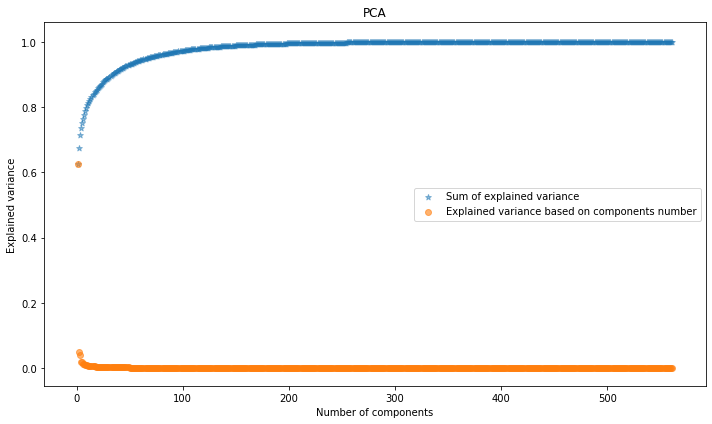

In [42]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
model = PCA()
model.fit_transform(X_train)
var_ratio = model.explained_variance_ratio_
var_ratio_sum = model.explained_variance_ratio_.cumsum()

X = [x for x in range(1,len(var_ratio_sum)+1)]

plt.figure(figsize=(10,6))
plt.scatter(x=X, y=var_ratio_sum, marker='*',alpha=0.5, label='Sum of explained variance')
plt.scatter(x=X, y=var_ratio, marker='o',alpha=0.6, label='Explained variance based on components number')
plt.legend()
plt.title('PCA')
plt.ylabel('Explained variance')
plt.xlabel('Number of components')
plt.tight_layout()

# plt.savefig("explained_variance_PCA_all_sensors.png")

In [43]:
var_ratio = model.explained_variance_ratio_
var_ratio_sum = model.explained_variance_ratio_.cumsum()

In [44]:
def pca_explained(var_ratio_sum, n):
    return len(list(filter(lambda x: x<n, var_ratio_sum)))

In [45]:
print('Based on PCA decomposition, {} components cover {}% of variance, and {} components cover {}% of variance'.format(pca_explained(var_ratio_sum, 0.95), 95, pca_explained(var_ratio_sum, 0.99), 99))

Based on PCA decomposition, 66 components cover 95% of variance, and 154 components cover 99% of variance


In [46]:
model_pca_2_components = PCA(n_components=2)
model_pca_2_components_data = model_pca_2_components.fit_transform(X_train)
var_ratio = model_pca_2_components.explained_variance_ratio_
var_ratio_sum = model_pca_2_components.explained_variance_ratio_.cumsum()
print('Explained variance for two components: {}'.format(var_ratio))
print('Twose two components cover {} of variance.'.format(var_ratio_sum))

Explained variance for two components: [0.625544 0.049130]
Twose two components cover [0.625544 0.674675] of variance.


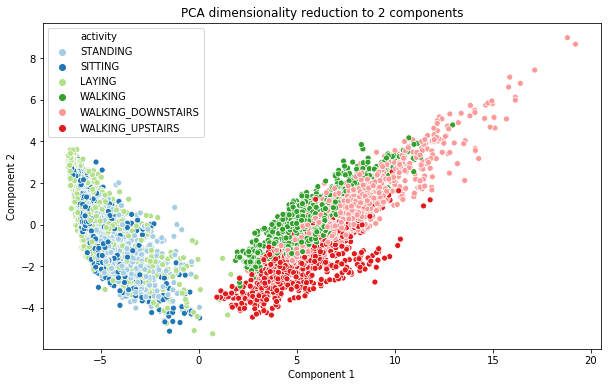

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=model_pca_2_components_data[:,0], 
                y=model_pca_2_components_data[:,1], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA dimensionality reduction to 2 components')
plt.show()

In [48]:
from sklearn.manifold import TSNE
import time

In [49]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7352 samples in 1.015s...
[t-SNE] Computed neighbors for 7352 samples in 40.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.399086
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.855431
[t-SNE] KL divergence after 300 iterations: 2.284878
t-SNE done! Time elapsed: 84.6246771812439 seconds


In [50]:
print(tsne_results.shape)

(7352, 2)


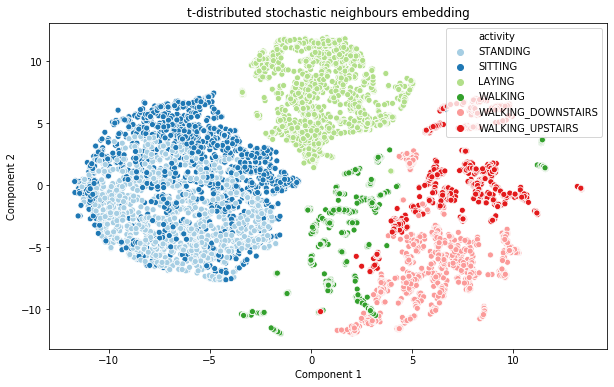

In [51]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=tsne_results[:,0], 
                y=tsne_results[:,1], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-distributed stochastic neighbours embedding')
plt.show()

On the visualisation above, t-SNE is used on full data set - using 561 features. As a way of a thumb, it is however a good practice to first reduce dimensionality with another algorithm and feed t-SNE with reduced number of features. Let's try this method and reduce dimensionality to let's say 40 components (with PCA).

In [53]:
from sklearn.pipeline import Pipeline

In [54]:
pipe = Pipeline((
    ('pca', PCA(n_components=40)),
    ('tsne', TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300))
))

In [55]:
tsne_reduced = pipe.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.063s...
[t-SNE] Computed neighbors for 7352 samples in 1.678s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.172673
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.544411
[t-SNE] KL divergence after 300 iterations: 2.279836


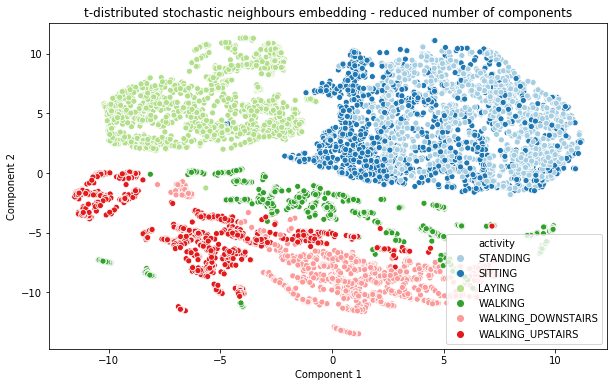

In [56]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=tsne_reduced[:,0], 
                y=tsne_reduced[:,1], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-distributed stochastic neighbours embedding - reduced number of components')
plt.show()

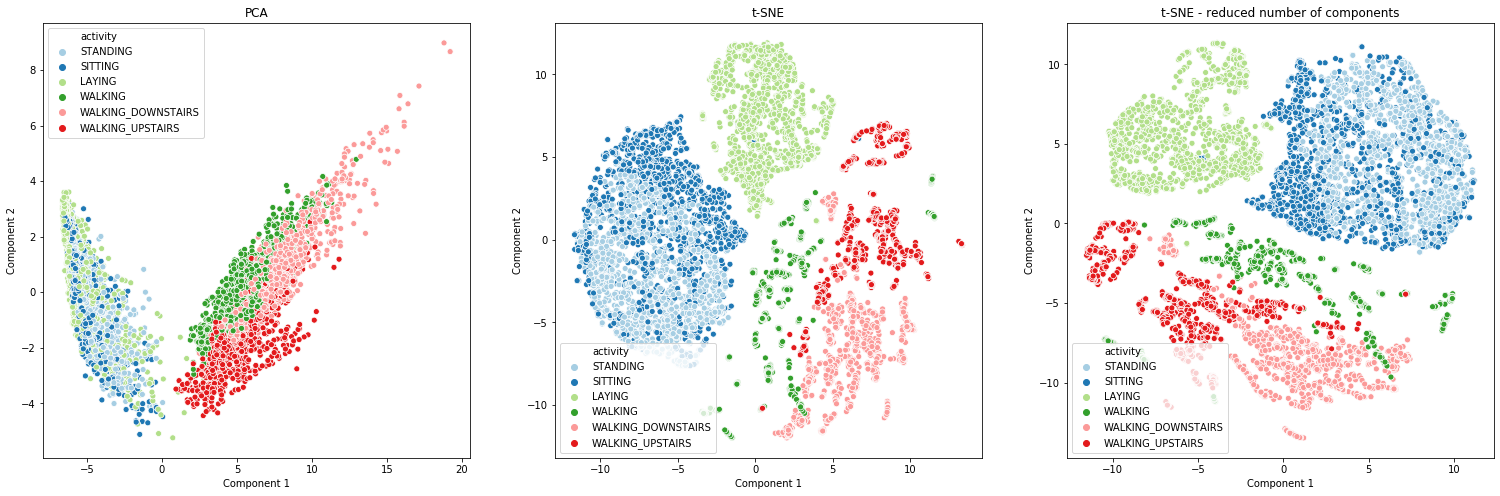

In [57]:
plt.figure(figsize=(26,8))

ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(x=model_pca_2_components_data[:,0], 
                y=model_pca_2_components_data[:,1], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA')

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(x=tsne_results[:,0], 
                y=tsne_results[:,1], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE')

ax2 = plt.subplot(1, 3, 3)
sns.scatterplot(x=tsne_reduced[:,0], 
                y=tsne_reduced[:,1], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE - reduced number of components')

plt.show()

Some conclusions based on data visualisation:
- With dimensionality reduction we can see if there are some distinct outliers that can be easily noticed
- PCA did a nice job to distinguish classes into two groups:
    - Steady activities (without movement): standing, sitting, laying
    - Dynamic activities (movement involved): walking, walking_downstairs, walking_upstairs
- We now may have an idea which classes during classification task may be confused (based on t-SNE)
    - standing and sitting (clearly they are totally mixed)
    - all walking types (although you may draw a line to separate them)
    - laying is clearly far from other classes

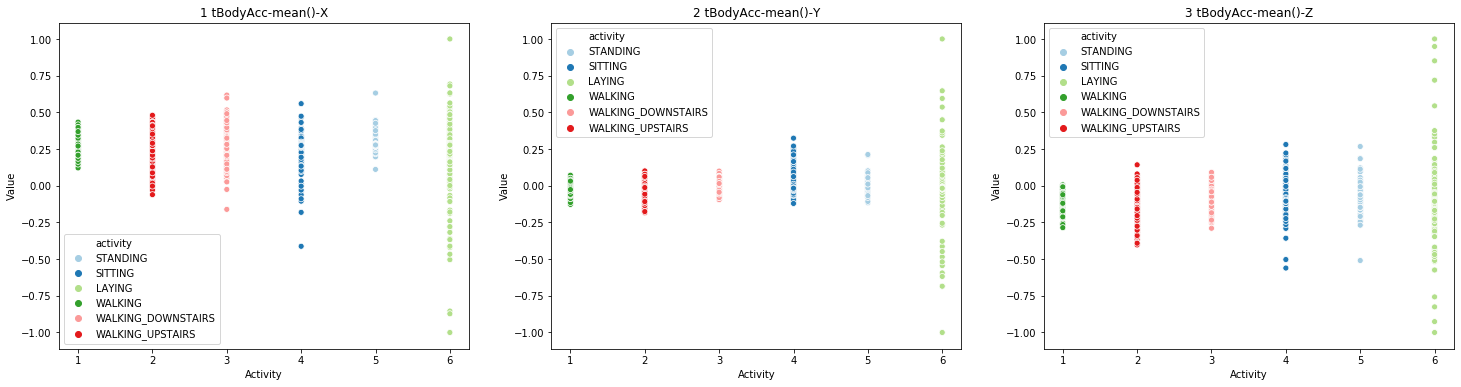

In [58]:
plt.figure(figsize=(25,6))

plt.subplot(1,3,1)
sns.scatterplot(x=y_train_with_label['label'],
                y=X_train['1 tBodyAcc-mean()-X'], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Activity')
plt.ylabel('Value')
plt.title('1 tBodyAcc-mean()-X')

plt.subplot(1,3,2)
sns.scatterplot(x=y_train_with_label['label'],
                y=X_train['2 tBodyAcc-mean()-Y'], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Activity')
plt.ylabel('Value')
plt.title('2 tBodyAcc-mean()-Y')

plt.subplot(1,3,3)
sns.scatterplot(x=y_train_with_label['label'],
                y=X_train['3 tBodyAcc-mean()-Z'], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Activity')
plt.ylabel('Value')
plt.title('3 tBodyAcc-mean()-Z')

plt.show()

Picture above shows all data. But let's compare acceleration for just one subject.

In [59]:
X_train_subject_id = pd.merge(left=X_train, 
                              right=subject_id_training, 
                              left_on=X_train.index,
                              right_on=subject_id_training.index, 
                              how='left')

In [211]:
y_train_subject_id = pd.merge(left=y_train_with_label, 
                              right=subject_id_training, 
                              left_on=y_train_with_label.index,
                              right_on=subject_id_training.index, 
                              how='left')

In [212]:
y_train_subject_id.drop(['key_0'], inplace=True, axis=1)

In [62]:
X_train_subject_id.drop(['key_0'], inplace=True, axis=1)

In [63]:
x_sub15 = X_train_subject_id.loc[X_train_subject_id['subject_id']==15]
y_sub15 = y_train_subject_id.loc[y_train_subject_id['subject_id']==15]

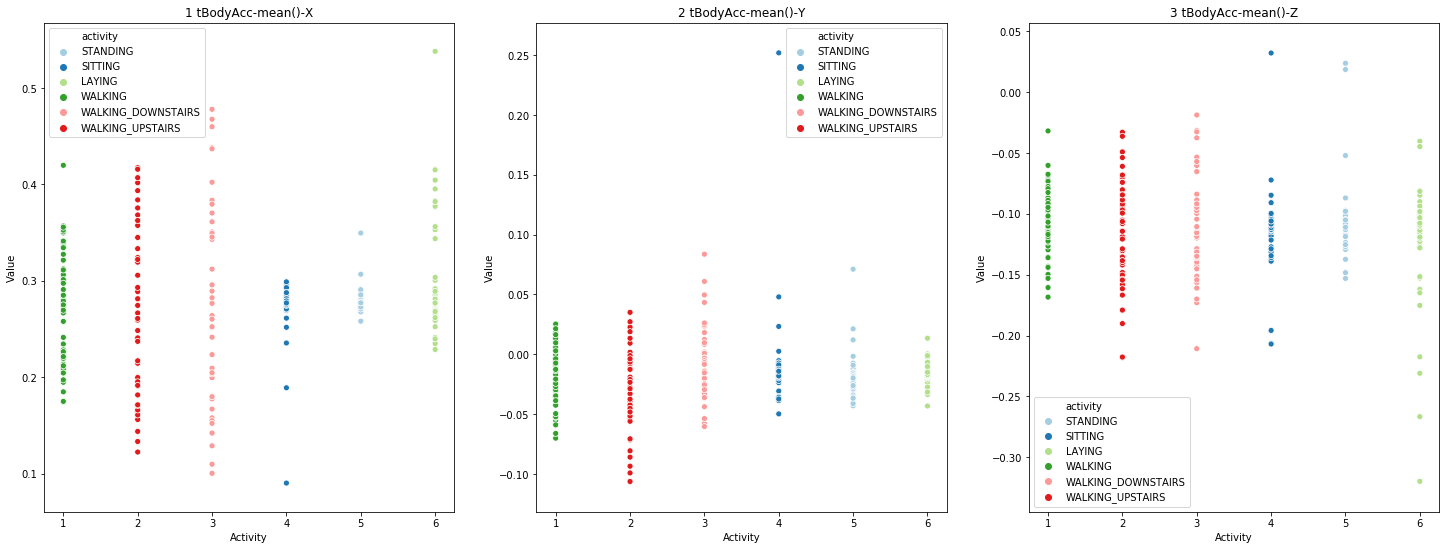

In [64]:
plt.figure(figsize=(25,9))

plt.subplot(1,3,1)
sns.scatterplot(x=y_sub15['label'],
                y=x_sub15['1 tBodyAcc-mean()-X'], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Activity')
plt.ylabel('Value')
plt.title('1 tBodyAcc-mean()-X')

plt.subplot(1,3,2)
sns.scatterplot(x=y_sub15['label'],
                y=x_sub15['2 tBodyAcc-mean()-Y'], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Activity')
plt.ylabel('Value')
plt.title('2 tBodyAcc-mean()-Y')

plt.subplot(1,3,3)
sns.scatterplot(x=y_sub15['label'],
                y=x_sub15['3 tBodyAcc-mean()-Z'], 
                hue=y_train_with_label['activity'],
                palette='Paired')
plt.xlabel('Activity')
plt.ylabel('Value')
plt.title('3 tBodyAcc-mean()-Z')

plt.show()

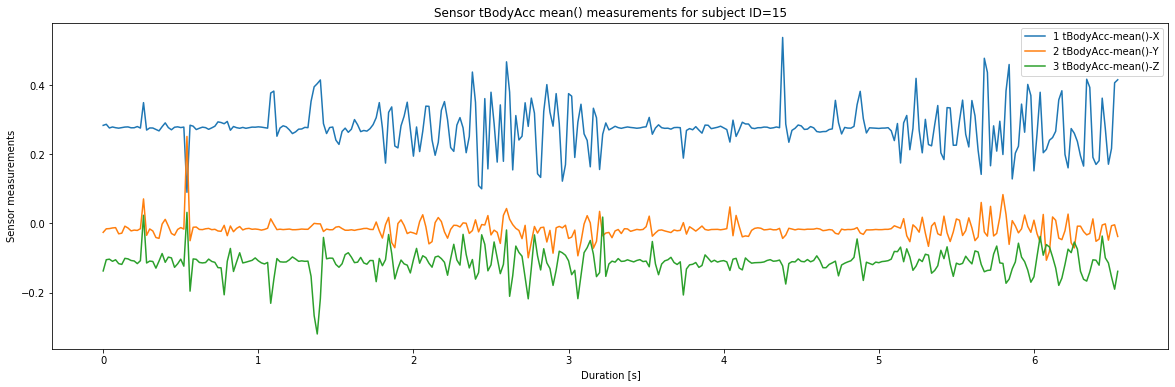

In [240]:
plt.figure(figsize=(20,6))
plt.plot((x_sub15.index - x_sub15.index.min()) / 50, x_sub15['1 tBodyAcc-mean()-X'], label='1 tBodyAcc-mean()-X')
plt.plot((x_sub15.index - x_sub15.index.min()) / 50, x_sub15['2 tBodyAcc-mean()-Y'], label='2 tBodyAcc-mean()-Y')
plt.plot((x_sub15.index - x_sub15.index.min())/ 50, x_sub15['3 tBodyAcc-mean()-Z'], label='3 tBodyAcc-mean()-Z')
plt.legend()
plt.title('Sensor tBodyAcc mean() measurements for subject ID=15')
plt.xlabel('Duration [s]')
plt.ylabel('Sensor measurements')
plt.show()

In [73]:
from sklearn.cluster import KMeans, SpectralClustering
kmeans = KMeans(n_clusters=6).fit(x_sub15)
clust = pd.crosstab(kmeans.labels_, y_sub15['activity'])
clust

activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
row_0,,,,,,
0,16,12,12,0,0,0
1,0,0,0,0,0,48
2,56,0,0,0,0,0
3,0,0,0,0,42,0
4,0,0,0,54,0,0
5,0,47,41,0,0,0


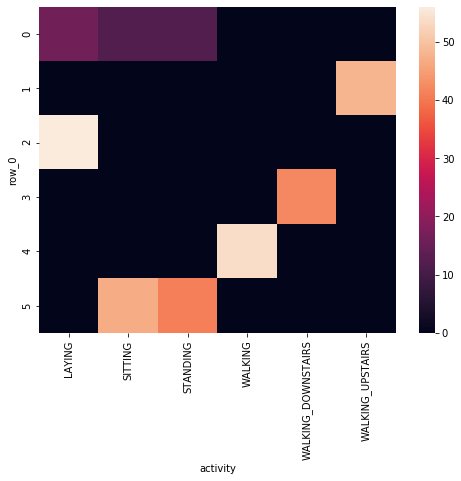

In [74]:
plt.figure(figsize=(8,6))
sns.heatmap(clust)
plt.show()

In [71]:
X_train.describe()

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,11 tBodyAcc-max()-Y,12 tBodyAcc-max()-Z,13 tBodyAcc-min()-X,14 tBodyAcc-min()-Y,15 tBodyAcc-min()-Z,16 tBodyAcc-sma(),17 tBodyAcc-energy()-X,18 tBodyAcc-energy()-Y,19 tBodyAcc-energy()-Z,20 tBodyAcc-iqr()-X,21 tBodyAcc-iqr()-Y,22 tBodyAcc-iqr()-Z,23 tBodyAcc-entropy()-X,24 tBodyAcc-entropy()-Y,25 tBodyAcc-entropy()-Z,"26 tBodyAcc-arCoeff()-X,1","27 tBodyAcc-arCoeff()-X,2","28 tBodyAcc-arCoeff()-X,3","29 tBodyAcc-arCoeff()-X,4","30 tBodyAcc-arCoeff()-Y,1","31 tBodyAcc-arCoeff()-Y,2","32 tBodyAcc-arCoeff()-Y,3","33 tBodyAcc-arCoeff()-Y,4","34 tBodyAcc-arCoeff()-Z,1","35 tBodyAcc-arCoeff()-Z,2","36 tBodyAcc-arCoeff()-Z,3","37 tBodyAcc-arCoeff()-Z,4","38 tBodyAcc-correlation()-X,Y","39 tBodyAcc-correlation()-X,Z","40 tBodyAcc-correlation()-Y,Z",41 tGravityAcc-mean()-X,42 tGravityAcc-mean()-Y,43 tGravityAcc-mean()-Z,44 tGravityAcc-std()-X,45 tGravityAcc-std()-Y,46 tGravityAcc-std()-Z,47 tGravityAcc-mad()-X,48 tGravityAcc-mad()-Y,49 tGravityAcc-mad()-Z,50 tGravityAcc-max()-X,51 tGravityAcc-max()-Y,52 tGravityAcc-max()-Z,53 tGravityAcc-min()-X,54 tGravityAcc-min()-Y,55 tGravityAcc-min()-Z,56 tGravityAcc-sma(),57 tGravityAcc-energy()-X,58 tGravityAcc-energy()-Y,59 tGravityAcc-energy()-Z,60 tGravityAcc-iqr()-X,61 tGravityAcc-iqr()-Y,62 tGravityAcc-iqr()-Z,63 tGravityAcc-entropy()-X,64 tGravityAcc-entropy()-Y,65 tGravityAcc-entropy()-Z,"66 tGravityAcc-arCoeff()-X,1","67 tGravityAcc-arCoeff()-X,2","68 tGravityAcc-arCoeff()-X,3","69 tGravityAcc-arCoeff()-X,4","70 tGravityAcc-arCoeff()-Y,1","71 tGravityAcc-arCoeff()-Y,2","72 tGravityAcc-arCoeff()-Y,3","73 tGravityAcc-arCoeff()-Y,4","74 tGravityAcc-arCoeff()-Z,1","75 tGravityAcc-arCoeff()-Z,2","76 tGravityAcc-arCoeff()-Z,3","77 tGravityAcc-arCoeff()-Z,4","78 tGravityAcc-correlation()-X,Y","79 tGravityAcc-correlation()-X,Z","80 tGravityAcc-correlation()-Y,Z",81 tBodyAccJerk-mean()-X,82 tBodyAccJerk-mean()-Y,83 tBodyAccJerk-mean()-Z,84 tBodyAccJerk-std()-X,85 tBodyAccJerk-std()-Y,86 tBodyAccJerk-std()-Z,87 tBodyAccJerk-mad()-X,88 tBodyAccJerk-mad()-Y,89 tBodyAccJerk-mad()-Z,90 tBodyAccJerk-max()-X,91 tBodyAccJerk-max()-Y,92 tBodyAccJerk-max()-Z,93 tBodyAccJerk-min()-X,94 tBodyAccJerk-min()-Y,95 tBodyAccJerk-min()-Z,96 tBodyAccJerk-sma(),97 tBodyAccJerk-energy()-X,98 tBodyAccJerk-energy()-Y,99 tBodyAccJerk-energy()-Z,100 tBodyAccJerk-iqr()-X,101 tBodyAccJerk-iqr()-Y,102 tBodyAccJerk-iqr()-Z,103 tBodyAccJerk-entropy()-X,104 tBodyAccJerk-entropy()-Y,105 tBodyAccJerk-entropy()-Z,"106 tBodyAccJerk-arCoeff()-X,1","107 tBodyAccJerk-arCoeff()-X,2","108 tBodyAccJerk-arCoeff()-X,3","109 tBodyAccJerk-arCoeff()-X,4","110 tBodyAccJerk-arCoeff()-Y,1","111 tBodyAccJerk-arCoeff()-Y,2","112 tBodyAccJerk-arCoeff()-Y,3","113 tBodyAccJerk-arCoeff()-Y,4","114 tBodyAccJerk-arCoeff()-Z,1","115 tBodyAccJerk-arCoeff()-Z,2","116 tBodyAccJerk-arCoeff()-Z,3","117 tBodyAccJerk-arCoeff()-Z,4","118 tBodyAccJerk-correlation()-X,Y","119 tBodyAccJerk-correlation()-X,Z","120 tBodyAccJerk-correlation()-Y,Z",121 tBodyGyro-mean()-X,122 tBodyGyro-mean()-Y,123 tBodyGyro-mean()-Z,124 tBodyGyro-std()-X,125 tBodyGyro-std()-Y,126 tBodyGyro-std()-Z,127 tBodyGyro-mad()-X,128 tBodyGyro-mad()-Y,129 tBodyGyro-mad()-Z,130 tBodyGyro-max()-X,131 tBodyGyro-max()-Y,132 tBodyGyro-max()-Z,133 tBodyGyro-min()-X,134 tBodyGyro-min()-Y,135 tBodyGyro-min()-Z,136 tBodyGyro-sma(),137 tBodyGyro-energy()-X,138 tBodyGyro-energy()-Y,139 tBodyGyro-energy()-Z,140 tBodyGyro-iqr()-X,141 tBodyGyro-iqr()-Y,142 tBodyGyro-iqr()-Z,143 tBodyGyro-entropy()-X,144 tBodyGyro-entropy()-Y,145 tBodyGyro-entropy()-Z,"146 tBodyGyro-arCoeff()-X,1","147 tBodyGyro-arCoeff()-X,2","148 tBodyGyro-arCoeff()-X,3","149 tBodyGyro-arCoeff()-X,4","150 tBodyGyro-arCoeff()-Y,1","151 tBodyGyro-arCoeff()-Y,2","152 tBodyGyro-arCoeff()-Y,3","153 tBodyGyro-arCoeff()-Y,4","154 tBodyGyro-arCoeff()-Z,1","15

Data is already scaled to range <-1, 1>.

In [76]:
import scipy.stats as stats

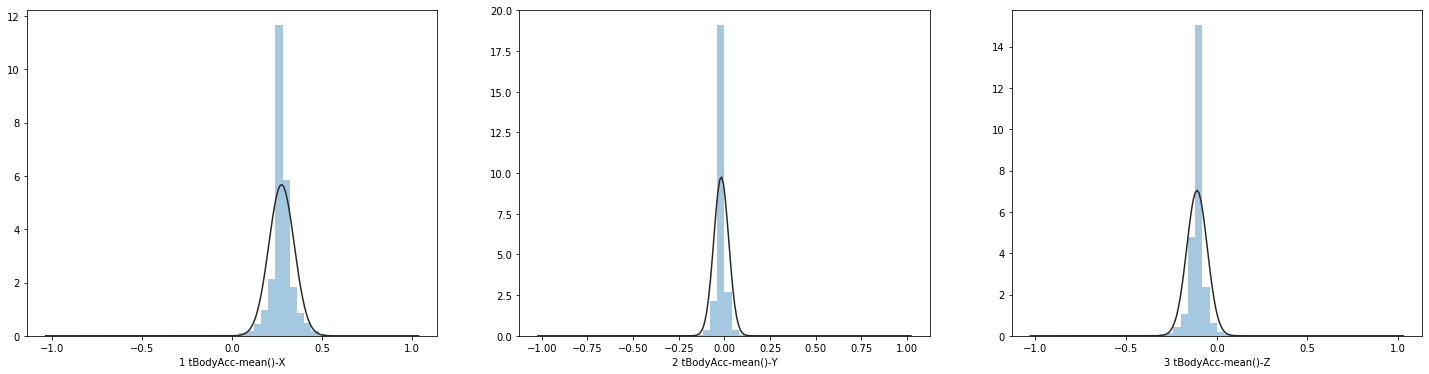

In [77]:
plt.figure(figsize=(25,6))

plt.subplot(1,3,1)
sns.distplot(X_train['1 tBodyAcc-mean()-X'], kde=False, bins=50, fit=stats.norm)

plt.subplot(1,3,2)
sns.distplot(X_train['2 tBodyAcc-mean()-Y'], kde=False, bins=50, fit=stats.norm)

plt.subplot(1,3,3)
sns.distplot(X_train['3 tBodyAcc-mean()-Z'], kde=False, bins=50, fit=stats.norm)

plt.show()

For case of visualisation, I add subject ID to X_train data.

### Feature selection
To deal with high data dimensionality, previously I had used PCA. But PCA creates new variables. <br>
So for now, I decide to continue with non-artifical variables by performing using Extra Tree Classifier in order to choose limited number of variables. The advantage here, is that those variables still have a "meaning".

In [78]:
from sklearn.ensemble import ExtraTreesClassifier

In [79]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train.values, y_train.values.ravel())

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [80]:
from sklearn.feature_selection import SelectFromModel

In [81]:
model = SelectFromModel(forest, prefit=True)
X_train_limited = model.transform(X_train)
print(X_train_limited.shape)

(7352, 156)


In [82]:
features_name = X_train.columns[model.get_support()]

In [84]:
# I'm taking only data with the highest significance based on Extra Tree Classifier future selection
X_train_limited = pd.DataFrame(X_train_limited, columns=list(features_name))

In [85]:
#adding subject_ID
X_train_limited = pd.merge(left=X_train_limited, 
                              right=subject_id_training, 
                              left_on=X_train_limited.index,
                              right_on=subject_id_training.index, 
                              how='left')

In [86]:
X_train_limited.drop(['key_0'], axis=1, inplace=True)

In [315]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

### Dealing with imbalanced classes

To deal with imbalanced data, I decide to try several approaches and perform further analysis on each of them. <br>
Used methods:
 - Random Under Sampling
 - Random Over Sampling
 - Tomek links

In [416]:
rus = RandomUnderSampler()
x_rus, y_rus = rus.fit_sample(X_train_limited, y_train)
print('Random Under Sampler: X shape: {}, y shape: {}.'.format(x_rus.shape, y_rus.shape))

ros = RandomOverSampler()
x_ros, y_ros = ros.fit_sample(X_train_limited, y_train)
print('Random Over Sampler: X shape: {}, y shape: {}.'.format(x_ros.shape, y_ros.shape))

tomek = TomekLinks()
x_tomek, y_tomek = tomek.fit_sample(X_train_limited, y_train)
print('Tomek links under sampling: X shape: {}, y shape: {}.'.format(x_tomek.shape, y_tomek.shape))


Random Under Sampler: X shape: (5916, 157), y shape: (5916, 1).
Random Over Sampler: X shape: (8442, 157), y shape: (8442, 1).
Tomek links under sampling: X shape: (7324, 157), y shape: (7324, 1).


Now I need to merge newly created dataframes to 'raw' ones to get subject ID and sort values by 'old index' so that data will remain in the right order.

In [409]:
def prepare_train_data(x, y, sampling_method):
    # Get previous index
    x, y = sampling_method.fit_sample(x, y)
    print('Shape after sampling: X shape: {}, y shape: {}.'.format(x.shape, y.shape))
    
    x['old_index'] = sampling_method.sample_indices_
    y['old_index'] = sampling_method.sample_indices_
    
    y = pd.merge(left=y, 
                  right=subject_id_training, 
                  left_on=y.old_index,
                  right_on=subject_id_training.index, 
                  how='left')
    
    y.sort_values(by=['old_index'], inplace=True)
    y.drop(['key_0', 'old_index'], axis=1, inplace=True)
    
    x.sort_values(by=['old_index'], inplace=True)
    x.drop(['old_index'], axis=1, inplace=True)
    return x, y

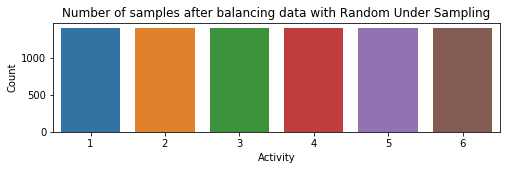

In [317]:
plt.figure(figsize=(8,2))
plt.title('Number of samples after balancing data with Random Under Sampling')
sns.countplot(y_ros['label'])
plt.ylabel('Count')
plt.xlabel('Activity')
plt.show()

Data was already modified and a lot of features were created basing on original data set. There were many typical operations like: median filtering, window averaging which are typical for dealing with time series data.

Now the approach I'm intending to try is to save the data using moving window. Windows will be created for each subject. <br>
Having data prepared in such way I will implement deep learning using LSTM cells, GRU cells and mixed approach.

In [311]:
X_train_limited.shape

(7352, 157)

In [92]:
count_by_subject_df = X_train_limited.groupby(['subject_id']).size().reset_index(name='counts')

In [97]:
count_by_subject_df.head(2)

,subject_id,counts
0,1,347
1,3,341


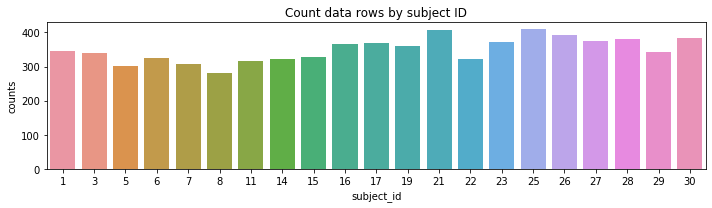

In [94]:
plt.figure(figsize=(10,3))
sns.barplot(x=count_by_subject_df['subject_id'],
           y=count_by_subject_df['counts'])
plt.title('Count data rows by subject ID')
plt.tight_layout()
plt.show()

In [95]:
subject_id_list = count_by_subject_df['subject_id'].values

It's also important to notice that there is a lack of some subject_id numbers and in fact there are just 21 of them. <br>
Luckily, number of data points for each subject is quite similar. Therefore I will not implement padding. <br>
Basing on the number of data points for each subject I can choose the window (sequence) length.

In [149]:
subject_id_list

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30], dtype=int64)

### Preparing data as sequences into training model

In [98]:
sequence_length = 30
print(f'Sequence length = {sequence_length}')

Sequence length = 30


In [99]:
def generate_sequence(sequence_length, data_by_id):
    data_by_id = data_by_id.drop(['subject_id'], axis=1)
    data_by_id = data_by_id.values
    num_of_elements = data_by_id.shape[0]
    for start in range(0, num_of_elements-sequence_length):
        yield data_by_id[start:start+sequence_length, :]

Dropping ID of subject as it is misleading and not necessary data.

In [100]:
seq_gen = (list(generate_sequence(sequence_length, X_train_limited[X_train_limited['subject_id']==id])) 
           for id in subject_id_list)

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(f'Shape of input data into Deep Learning model is: {seq_array.shape}')

In [103]:
def generate_label(sequence_length, data_by_id):
    data_by_id = data_by_id['label']
    data_by_id = data_by_id.values
    num_of_elements = data_by_id.shape[0]
    return data_by_id[sequence_length:num_of_elements]

In [104]:
label_gen = [generate_label(sequence_length, y_train_subject_id[y_train_subject_id['subject_id']==id]) 
             for id in subject_id_list]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array = label_array.reshape(len(label_array), 1)

print(f'Shape of label array: {label_array.shape}')

In [107]:
n_timesteps = seq_array.shape[1]
n_features = seq_array.shape[2]

print(f'Number of timesteps: {n_timesteps} \n')
print(f'Number of features: {n_features}')

Number of timesteps: 30 

Number of features: 156


In [295]:
def prepare_train_data_sequence(sequence_length, x, y, subject_id_list):
    seq_gen = (list(generate_sequence(sequence_length, x[x['subject_id']==id])) 
               for id in subject_id_list)

    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    print(f'Shape of input data into Deep Learning model is: {seq_array.shape}')
    
    label_gen = [generate_label(sequence_length, y[y['subject_id']==id]) 
                 for id in subject_id_list]

    label_array = np.concatenate(label_gen).astype(np.float32)
    label_array = label_array.reshape(len(label_array), 1)

    print(f'Shape of label array: {label_array.shape}')
    
    n_timesteps = seq_array.shape[1]
    n_features = seq_array.shape[2]

    print(f'Number of timesteps: {n_timesteps} \n')
    print(f'Number of features: {n_features}')
    
    #offset
    label_array = label_array-1
    
    one_hot_encoder = OneHotEncoder()
    one_hot_encoder.fit(label_array)

    y_train_one_hot = one_hot_encoder.transform(label_array)
    print(f'Shape of label array: {y_train_one_hot.shape}')

    n_out = y_train_one_hot.shape[1]
    print(f'Shape of output: {n_out}')
    
    return seq_array, label_array, y_train_one_hot, n_timesteps, n_features, n_out

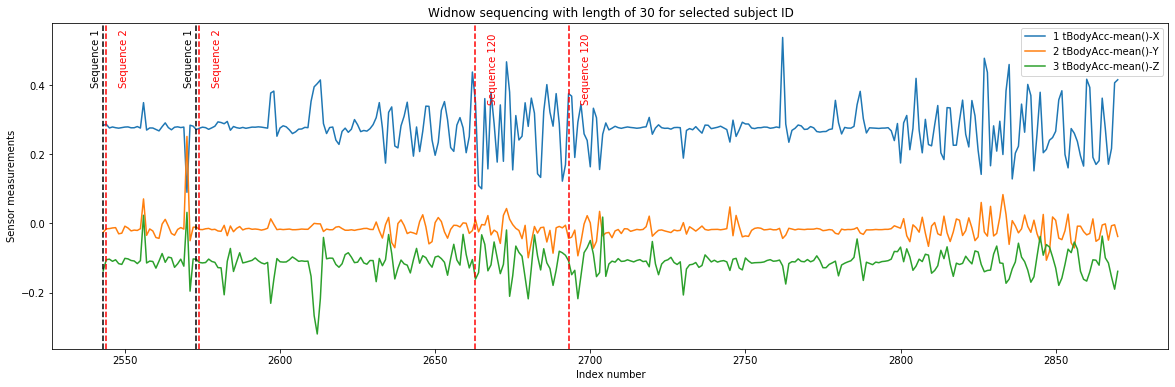

In [269]:
plt.figure(figsize=(20,6))
plt.plot(x_sub15.index, x_sub15['1 tBodyAcc-mean()-X'], label='1 tBodyAcc-mean()-X')
plt.plot(x_sub15.index, x_sub15['2 tBodyAcc-mean()-Y'], label='2 tBodyAcc-mean()-Y')
plt.plot(x_sub15.index, x_sub15['3 tBodyAcc-mean()-Z'], label='3 tBodyAcc-mean()-Z')

#Sequence 1
plt.axvline(x_sub15.index.min(), color='black', ls='--')
plt.text(x_sub15.index.min()-4, .4, 'Sequence 1',rotation=90, fontsize=10)

plt.axvline(x_sub15.index.min() + 30, color='black', ls='--')
plt.text(x_sub15.index.min() + 30 -4, .4, 'Sequence 1',rotation=90, fontsize=10)

#Sequence 2
plt.axvline(x_sub15.index.min()+1, color='red', ls='--')
plt.text(x_sub15.index.min()+4+1, .4, 'Sequence 2',rotation=90, fontsize=10, c='red')

plt.axvline(x_sub15.index.min() + 31, color='red', ls='--')
plt.text(x_sub15.index.min() + 31 +4, .4, 'Sequence 2',rotation=90, fontsize=10, c='red')

#Sequence 120
plt.axvline(x_sub15.index.min()+120, color='red', ls='--')
plt.text(x_sub15.index.min()+4+120, .35, 'Sequence 120',rotation=90, fontsize=10, c='red')

plt.axvline(x_sub15.index.min() + 150, color='red', ls='--')
plt.text(x_sub15.index.min() + 150 +4, .35, 'Sequence 120',rotation=90, fontsize=10, c='red')

plt.legend()
plt.title('Widnow sequencing with length of 30 for selected subject ID')
plt.xlabel('Index number')
plt.ylabel('Sensor measurements')
plt.show()

### Multiclass classification - One Hot encoding on target class

Label array: <br>
Each value is corresponding to the one window. We have 6 classes so in order to prepare this data into Keras model, I will apply one-hot encoding approach.

In [109]:
from sklearn.preprocessing import OneHotEncoder

In [108]:
#offset
label_array = label_array-1

In [110]:
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(label_array)

y_train_one_hot = one_hot_encoder.transform(label_array)
print(f'Shape of label array: {y_train_one_hot.shape}')

n_out = y_train_one_hot.shape[1]
print(f'Shape of output: {n_out}')

# 4) Creating models, hyperparameter tuning

### 4.1 Initial model on unbalanced data to test the approach with neural networks

In [319]:
import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU

I'm createing sequential model using LSTM cells. <br>
 - I'm applying dropout after each layer to reduce overfitting
 - Using ADAM version of stochastic gradient descent
 - The cost function will be categorical crossentropy
 - Early stopping - after few epochs with no improvement, training stops

In [118]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [119]:
model = Sequential()

model.add(LSTM(
         input_shape=(n_timesteps, n_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=n_out, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy', recall_m, precision_m, f1_m])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           102800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 133,306
Trainable params: 133,306
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
model_path = 'classification_model.h5'

In [121]:
history = model.fit(seq_array, y_train_one_hot, epochs=50, batch_size=30, validation_split=0.2, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Train on 5377 samples, validate on 1345 samples
Epoch 1/50
5377/5377 [==============================] - 11s 2ms/step - loss: 0.5078 - acc: 0.8207 - recall_m: 0.7610 - precision_m: 0.8441 - f1_m: 0.7850 - val_loss: 0.3027 - val_acc: 0.8967 - val_recall_m: 0.8914 - val_precision_m: 0.8972 - val_f1_m: 0.8943
Epoch 2/50
5377/5377 [==============================] - 41s 8ms/step - loss: 0.2752 - acc: 0.9076 - recall_m: 0.9037 - precision_m: 0.9123 - f1_m: 0.9079 - val_loss: 0.2228 - val_acc: 0.9309 - val_recall_m: 0.9257 - val_precision_m: 0.9337 - val_f1_m: 0.9295
Epoch 3/50
5377/5377 [==============================] - 15s 3ms/step - loss: 0.2307 - acc: 0.9282 - recall_m: 0.9258 - precision_m: 0.9309 - f1_m: 0.9283 - val_loss: 0.1787 - val_acc: 0.9316 - val_recall_m: 0.9264 - val_precision_m: 0.9319 - val_f1_m: 0.9291
Epoch 4/50
5377/5377 [==============================] - 12s 2ms/step - loss: 0.2107 - acc: 0.9349 - recall_m: 0.9323 - precision_m: 0.9373 - f1_m: 0.9347 - val_loss: 0.1603 - 

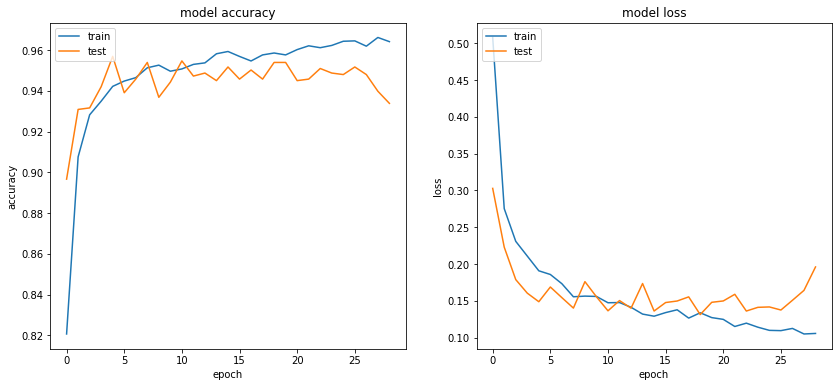

In [122]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


In [125]:
scores = model.evaluate(seq_array, y_train_one_hot, verbose=1, batch_size=60)
print('Accurracy using part of training data as validation data: {}'.format(scores[1]))

6722/6722 [==============================] - 3s 427us/step
Accurracy using part of training data as validation data: 0.9573043622774795


In [126]:
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=60)
y_true = label_array

6722/6722 [==============================] - 3s 412us/step


In [127]:
cm = confusion_matrix(y_true, y_pred)

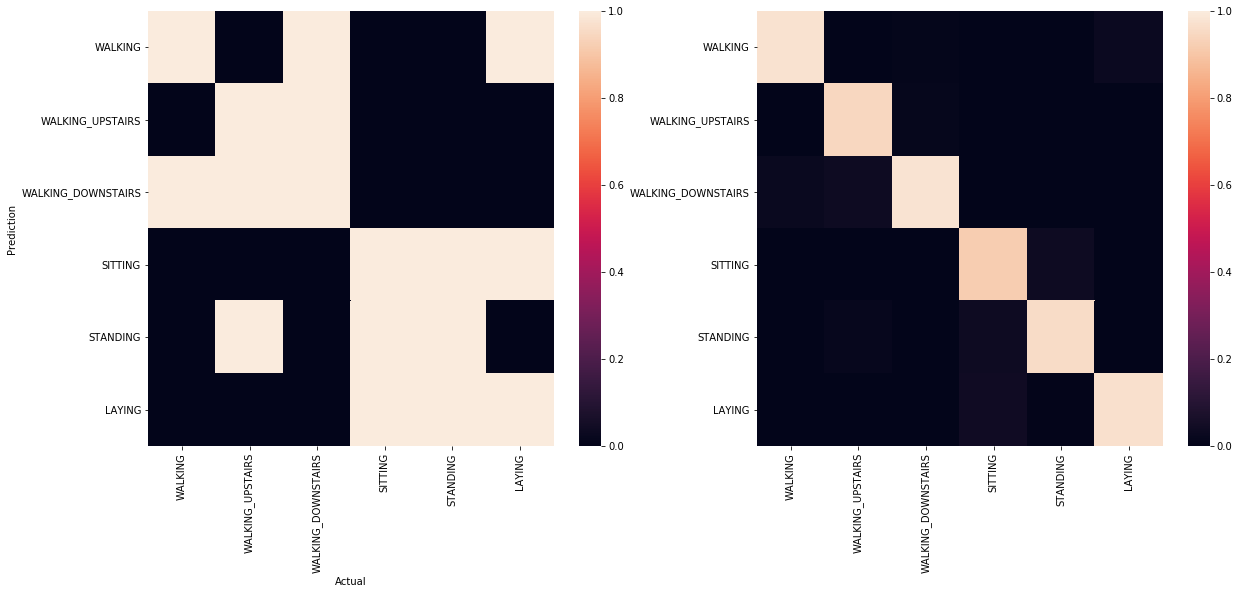

In [129]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.heatmap(cm, vmin=0, vmax=1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.xticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=90)
plt.yticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=360)


plt.subplot(1,2,2)
sns.heatmap(cm / sum(cm), vmin=0, vmax=1)
plt.xticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=90)
plt.yticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=360)

plt.show()

In [130]:
from matplotlib.colors import ListedColormap

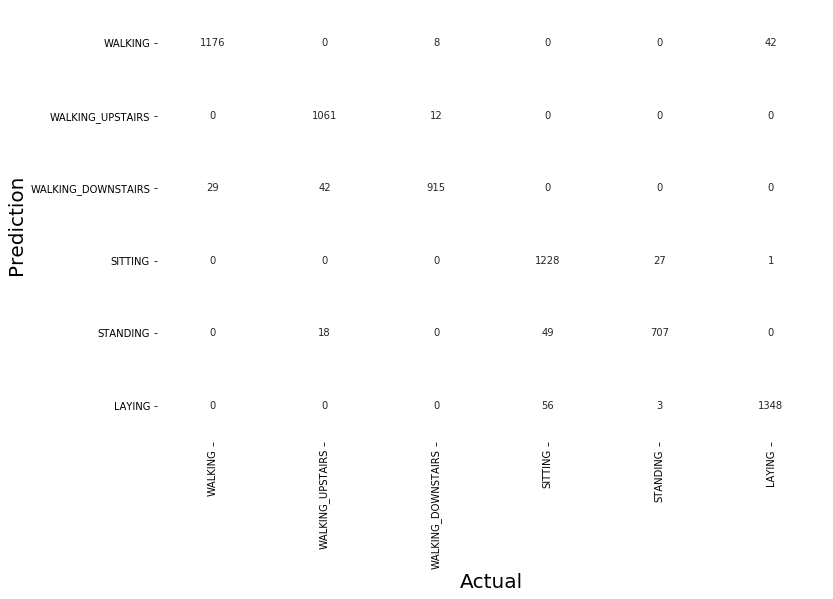

In [132]:
plt.figure(figsize=(12,8))

sns.heatmap(cm, vmin=0, vmax=1, cmap=ListedColormap(['white']), annot=True,fmt='g', cbar=False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Prediction', fontsize=20)
plt.xticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=90)
plt.yticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=360)

plt.show()

In [133]:
from sklearn.metrics import recall_score, precision_score, f1_score

Adjusting recall and precision to calculate this metrics more correctly as we are dealing with imbalanced data.

In [168]:
print(f'Recall: {recall_score(y_true, y_pred, average="weighted")}')  
print(f'Precision: {precision_score(y_true, y_pred, average="weighted")}')
print(f'F1 score: {f1_score(y_true, y_pred, average="weighted")}')

Recall: 0.9573043736983041
Precision: 0.9580537613367974
F1 score: 0.9572652410032713


 - This is the result of training model on slightly imbalanced data.
 - Already it can be stated that results are fairly good.
 - From the results I can state that the approach is correct - it needs some more tweaking
 - Using gate cells (LSTM, GRU) in this case is justified - we are dealing with time-series data. This cells comparing to classical RNN networks have the ability to recognize patterns along several inputs.

### 4.2 Grid search and choosing final model

In [290]:
#working on copy of the dataframes:
x, y = X_train_limited.copy(), y_train.copy

In [291]:
def define_model(n_timesteps, n_features, n_out):
    model = Sequential()

    model.add(LSTM(
             input_shape=(n_timesteps, n_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=n_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy', recall_m, precision_m, f1_m])
    return model

In [318]:
# iterate over sampling methods
resampling_results = dict()

for sampling_method, sampling_method_name in zip([rus, ros, tomek], ['rus', 'ros', 'tomek']) :
    x, y = X_train_limited.copy(), y_train.copy
    
    print('*' *20)
    print('sampling method: ', sampling_method)
    
    x, y = prepare_train_data(x, y, sampling_method)
    seq_array, label_array, y_train_one_hot, n_timesteps, n_features, n_out = prepare_train_data_sequence(sequence_length, x, y, subject_id_list)
    
    model = define_model(n_timesteps, n_features, n_out)
    
    history = model.fit(seq_array, y_train_one_hot, epochs=50, batch_size=30, validation_split=0.2, verbose=0,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
          )

    scores = model.evaluate(seq_array, y_train_one_hot, verbose=1, batch_size=60)
    
    
    y_pred = model.predict_classes(seq_array,verbose=1, batch_size=60)
    y_true = label_array
    
    cm = confusion_matrix(y_true, y_pred)
    
    print('*' * 40)
    print('SAMPLING METHOD: ', sampling_method)
    print('Accurracy using part of training data as validation data: {}'.format(scores[1]))
    print(f'Recall: {recall_score(y_true, y_pred, average="weighted")}')  
    print(f'Precision: {precision_score(y_true, y_pred, average="weighted")}')
    print(f'F1 score: {f1_score(y_true, y_pred, average="weighted")}')
    print('*' * 40)
    
    resampling_results[sampling_method_name] = dict()
    
    resampling_results[sampling_method_name]['Accuracy'] = scores[1]
    resampling_results[sampling_method_name]['Recall'] = {recall_score(y_true, y_pred, average="weighted")}
    resampling_results[sampling_method_name]['Precision'] = {precision_score(y_true, y_pred, average="weighted")}
    resampling_results[sampling_method_name]['F1'] = {f1_score(y_true, y_pred, average="weighted")}
    resampling_results[sampling_method_name]['cm'] = cm 

********************
sampling method:  RandomUnderSampler(random_state=None, replacement=False,
                   sampling_strategy='auto')
Shape after sampling: X shape: (5916, 157), y shape: (5916, 1).
Shape of input data into Deep Learning model is: (5286, 30, 156)
Shape of label array: (5286, 1)
Number of timesteps: 30 

Number of features: 156
Shape of label array: (5286, 6)
Shape of output: 6
5286/5286 [==============================] - 6s 1ms/step
****************************************
SAMPLING METHOD:  RandomUnderSampler(random_state=None, replacement=False,
                   sampling_strategy='auto')
Accurracy using part of training data as validation data: 0.9608399452605664
Recall: 0.9608399545970489
Precision: 0.9612343755130398
F1 score: 0.9608518470008636
****************************************
********************
sampling method:  RandomOverSampler(random_state=None, sampling_strategy='auto')
Shape after sampling: X shape: (8442, 157), y shape: (8442, 1).
Shape of 

**Random Oversampling did the best, so I continue to further prepare model with data balanced this way.**

In [322]:
x, y = X_train_limited.copy(), y_train.copy
    
x, y = prepare_train_data(x, y, ros)
seq_array, label_array, y_train_one_hot, n_timesteps, n_features, n_out = prepare_train_data_sequence(sequence_length, x, y, subject_id_list)

Shape after sampling: X shape: (8442, 157), y shape: (8442, 1).
Shape of input data into Deep Learning model is: (7812, 30, 156)
Shape of label array: (7812, 1)
Number of timesteps: 30 

Number of features: 156
Shape of label array: (7812, 6)
Shape of output: 6


In [351]:
def define_model_after_resampling(n_timesteps, n_features, n_out, layer_type, dropout, optimizer):
    model = Sequential()

    model.add(layer_type(
             input_shape=(n_timesteps, n_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(dropout))

    model.add(layer_type(
              units=50,
              return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(units=n_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy', recall_m, precision_m, f1_m])
    return model

**Grid search to find the most suitable: layer type, dropout rate, optimizer and batch size**

In [371]:
results = dict()
counter=1
for layer, layer_name in zip([LSTM, GRU], ['LSTM', 'GRU']):
    for dropout in [0.1, 0.2]:
        for optimizer in ['RMSprop', 'adam']:
            for batch_size in [30, 60]:
                
                print('*' * 40)
                print('Layer: ', layer_name)
                print('dropout: ', dropout)
                print('optimizer: ', optimizer)
                print('batch_size: ', batch_size)
                print('------------------')
                
                model = define_model_after_resampling(n_timesteps, n_features, n_out, layer, dropout, optimizer)
                
                history = model.fit(seq_array, y_train_one_hot, epochs=50, batch_size=batch_size, validation_split=0.2, verbose=0,
                                  callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
                                  )
                
                scores = model.evaluate(seq_array, y_train_one_hot, verbose=1, batch_size=batch_size)
    
    
                y_pred = model.predict_classes(seq_array,verbose=1, batch_size=batch_size)
                y_true = label_array

                cm = confusion_matrix(y_true, y_pred)
                
                accuracy = scores[1]
                recall = recall_score(y_true, y_pred, average="weighted")
                precision = precision_score(y_true, y_pred, average="weighted")
                f1 = f1_score(y_true, y_pred, average="weighted")
                print('Accurracy: {}'.format(accuracy))
                print(f'Recall: {recall}')  
                print(f'Precision: {precision}')
                print(f'F1 score: {f1}')
                print('*' * 40)

                results[counter] = [layer_name, dropout, optimizer, batch_size, accuracy, recall, precision, f1]
                counter += 1

****************************************
Layer:  LSTM
dropout:  0.1
optimizer:  RMSprop
batch_size:  30
------------------
7812/7812 [==============================] - 12s 2ms/step
Accurracy: 0.960061425941148
Recall: 0.9600614439324117
Precision: 0.9603276683227137
F1 score: 0.9600840506756959
****************************************
****************************************
Layer:  LSTM
dropout:  0.1
optimizer:  RMSprop
batch_size:  60
------------------
7812/7812 [==============================] - 11s 1ms/step
Accurracy: 0.9682539609903198
Recall: 0.9682539682539683
Precision: 0.9684296200206566
F1 score: 0.9682849389137743
****************************************
****************************************
Layer:  LSTM
dropout:  0.1
optimizer:  adam
batch_size:  30
------------------
7812/7812 [==============================] - 14s 2ms/step
Accurracy: 0.9681259419328423
Recall: 0.9681259600614439
Precision: 0.9683700775602638
F1 score: 0.9681628204916954
*******************************

In [378]:
tuning_df = pd.DataFrame.from_dict(results, 
                                   orient='index', 
                                   columns=['layer', 'dropout_rate', 'optimizer', 'batch_size', 'accuracy', 'recall', 'precision', 'f1_score'])

In [380]:
tuning_df

,layer,dropout_rate,optimizer,batch_size,accuracy,recall,precision,f1_score
1,LSTM,0.1,RMSprop,30,0.960061,0.960061,0.960328,0.960084
2,LSTM,0.1,RMSprop,60,0.968254,0.968254,0.968430,0.968285
3,LSTM,0.1,adam,30,0.968126,0.968126,0.968370,0.968163
4,LSTM,0.1,adam,60,0.967998,0.967998,0.968157,0.968012
5,LSTM,0.2,RMSprop,30,0.965950,0.965950,0.966386,0.966005
6,LSTM,0.2,RMSprop,60,0.964158,0.964158,0.964190,0.964152
7,LSTM,0.2,adam,30,0.961470,0.961470,0.961607,0.961438
8,LSTM,0.2,adam,60,0.963646,0.963646,0.964009,0.963704
9,GRU,0.1,RMSprop,30,0.972222,0.972222,0.972400,0.972233
10,GRU,0.1,RMSprop,60,0.963774,0.963774,0.964439,0.963822


**Based on grid search, I will produce final prediction on test set basing on the following model:**

In [388]:
tuning_df.loc[tuning_df['accuracy'].idxmax()]

layer                GRU
dropout_rate         0.1
optimizer        RMSprop
batch_size            30
accuracy        0.972222
recall          0.972222
precision         0.9724
f1_score        0.972233
Name: 9, dtype: object

### 4.3 Training model with best parameters after grid search

In [389]:
x, y = X_train_limited.copy(), y_train.copy
    
x, y = prepare_train_data(x, y, ros)
seq_array, label_array, y_train_one_hot, n_timesteps, n_features, n_out = prepare_train_data_sequence(sequence_length, x, y, subject_id_list)

Shape after sampling: X shape: (8442, 157), y shape: (8442, 1).
Shape of input data into Deep Learning model is: (7812, 30, 156)
Shape of label array: (7812, 1)
Number of timesteps: 30 

Number of features: 156
Shape of label array: (7812, 6)
Shape of output: 6


In [392]:
model = define_model_after_resampling(n_timesteps, n_features, n_out, layer_type=GRU, dropout=0.1, optimizer='RMSprop')
                
history = model.fit(seq_array, y_train_one_hot, epochs=50, batch_size=30, validation_split=0.2, verbose=1,
                  callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')]
                  )

scores = model.evaluate(seq_array, y_train_one_hot, verbose=1, batch_size=batch_size)


y_pred = model.predict_classes(seq_array,verbose=1, batch_size=batch_size)
y_true = label_array

Train on 6249 samples, validate on 1563 samples
Epoch 1/50
6249/6249 [==============================] - 28s 4ms/step - loss: 0.3797 - acc: 0.8726 - recall_m: 0.8357 - precision_m: 0.8897 - f1_m: 0.8550 - val_loss: 0.1859 - val_acc: 0.9520 - val_recall_m: 0.9463 - val_precision_m: 0.9535 - val_f1_m: 0.9498
Epoch 2/50
6249/6249 [==============================] - 41s 7ms/step - loss: 0.2125 - acc: 0.9386 - recall_m: 0.9365 - precision_m: 0.9411 - f1_m: 0.9387 - val_loss: 0.3011 - val_acc: 0.8893 - val_recall_m: 0.8880 - val_precision_m: 0.8896 - val_f1_m: 0.8888
Epoch 3/50
6249/6249 [==============================] - 22s 3ms/step - loss: 0.1871 - acc: 0.9462 - recall_m: 0.9446 - precision_m: 0.9463 - f1_m: 0.9455 - val_loss: 0.2031 - val_acc: 0.9296 - val_recall_m: 0.9226 - val_precision_m: 0.9306 - val_f1_m: 0.9263
Epoch 4/50
6249/6249 [==============================] - 19s 3ms/step - loss: 0.1659 - acc: 0.9530 - recall_m: 0.9520 - precision_m: 0.9540 - f1_m: 0.9530 - val_loss: 0.1544 - 

# 5) Graphical and descriptive model assessment
### 5. 1Preparing test data and creating prediction on test data.

In [447]:
X_test_limited = pd.DataFrame(X_test, columns=list(features_name))

#adding subject_ID
X_test_limited = pd.merge(left=X_test_limited, 
                              right=subject_id_testing, 
                              left_on=X_test_limited.index,
                              right_on=subject_id_testing.index, 
                              how='left')

X_test_limited.drop(['key_0'], axis=1, inplace=True)

In [448]:
def prepare_test_data(x, y, sampling_method):
    # Get previous index
    x, y = sampling_method.fit_sample(x, y)
    print('Shape after sampling: X shape: {}, y shape: {}.'.format(x.shape, y.shape))
    
    x['old_index'] = sampling_method.sample_indices_
    y['old_index'] = sampling_method.sample_indices_
    
    y = pd.merge(left=y, 
                  right=subject_id_testing, 
                  left_on=y.old_index,
                  right_on=subject_id_testing.index, 
                  how='left')
    
    y.sort_values(by=['old_index'], inplace=True)
    y.drop(['key_0', 'old_index'], axis=1, inplace=True)
    
    x.sort_values(by=['old_index'], inplace=True)
    x.drop(['old_index'], axis=1, inplace=True)
    return x, y

In [449]:
x, y = X_test_limited.copy(), y_test.copy()

In [450]:
#list of unique subject ID's in test set
subject_id_list_test = subject_id_testing['subject_id'].unique().tolist()

In [451]:
x, y = prepare_test_data(x, y, ros)

Shape after sampling: X shape: (3222, 157), y shape: (3222, 1).


In [453]:
test_seq_array, test_label_array, test_y_one_hot, test_n_timesteps, test_n_features, test_n_out = prepare_train_data_sequence(sequence_length, x, y, subject_id_list_test)

Shape of input data into Deep Learning model is: (2952, 30, 156)
Shape of label array: (2952, 1)
Number of timesteps: 30 

Number of features: 156
Shape of label array: (2952, 6)
Shape of output: 6


### 5.2 Evaluation on test data

In [454]:
test_scores = model.evaluate(test_seq_array, test_y_one_hot, verbose=1, batch_size=30)
print('Accurracy os test data: {}'.format(test_scores[1]))

2952/2952 [==============================] - 3s 889us/step
Accurracy os test data: 0.9342818255952703


In [455]:
y_pred_test = model.predict_classes(test_seq_array, verbose=1, batch_size=30)
y_true_test = test_label_array

2952/2952 [==============================] - 3s 868us/step


In [456]:
cm_test = confusion_matrix(y_true_test, y_pred_test)

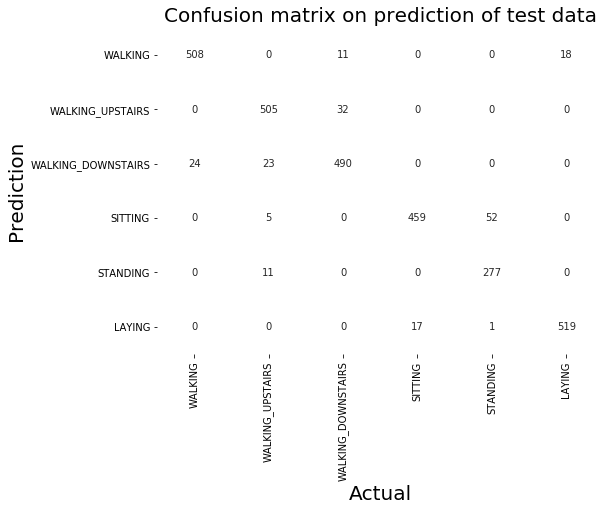

In [459]:
plt.figure(figsize=(8,6))

sns.heatmap(cm_test, vmin=0, vmax=1, cmap=ListedColormap(['white']), annot=True,fmt='g', cbar=False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Prediction', fontsize=20)
plt.xticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=90)
plt.yticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=360)
plt.title('Confusion matrix on prediction of test data', fontsize=20)
plt.show()

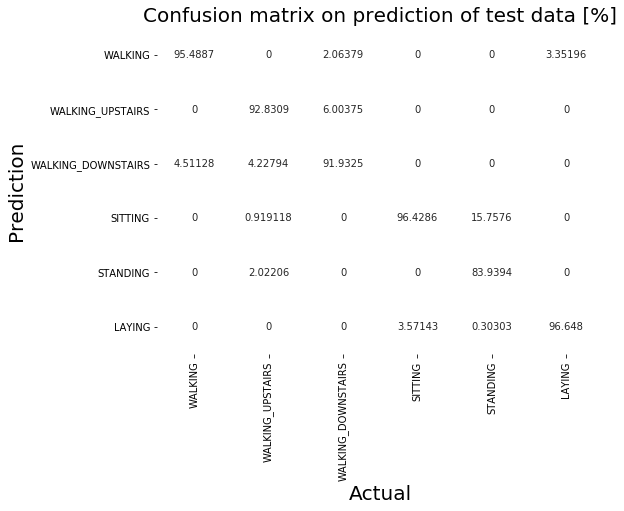

In [464]:
plt.figure(figsize=(8,6))

sns.heatmap(cm_test / sum(cm_test) * 100 , vmin=0, vmax=1, cmap=ListedColormap(['white']), annot=True,fmt='g', cbar=False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Prediction', fontsize=20)
plt.xticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=90)
plt.yticks(np.arange(0.5,6.5,1), list(y_train_label['activity']), rotation=360)
plt.title('Confusion matrix on prediction of test data [%]', fontsize=20)
plt.show()

In [458]:
print(f'Recall: {recall_score(y_true_test, y_pred_test, average="weighted")}')  
print(f'Precision: {precision_score(y_true_test, y_pred_test, average="weighted")}')
print(f'F1 score: {f1_score(y_true_test, y_pred_test, average="weighted")}')

Recall: 0.9342818428184282
Precision: 0.9360672275588914
F1 score: 0.9344920493309636


### 5.3 Scores obtained on final prediction using test data
- Accurracy: 0.9342818255952703
- Recall: 0.9342818428184282
- Precision: 0.9360672275588914
- F1 score: 0.9344920493309636


Model get slightly worse resluts on the test set. Although I think it is reasonable to say that the results are fine. <br>
Now looking and confussion matrix we can easily see which classes were mixed. 
- The worst score is for Standing - it was often mixed with Sitting class. We can recall when we look back at visualisations for t-SNE, that those in fact were two most mixed classes.
- The best accuracy was for Laying class - it was only confused with Walking class which seems quire strange from human point of view as in our perception, those classes are really different. But based on sensors measurements they may seem similar.
- Also interesting fact, that Walking was only confused with Walking Downstairs, there wasn't even one case when Walking was confused with Walking Upstairs.

Looking at the result, maybe by doing some feature engineering on walking classes we could create features that could help to distunguish those classes.

# 6) Summary, discussion on encountered problems 

To sum up, in this task we're dealing with:
- multiclass classification (6 labels)
- unbalanced data set
- high dimensionality (561 features)
- time series task

#### High dimensionality
To visualise data set 2-D, PCA and t-SNE was used to reduce dimensionality. <br>
To create model working with reduced number of features, **Extra Tree Classifier** was used to feature selection. <br>
156 features with biggest impact on predicted variable was used in final model.

#### Time series task
I have decided to use **GRU cells**. At first I have tried classical sequential model with Dense layers, but GRU cells did the better job. <br>
It is reasonable to use this kind of cells to deal with time-series. Other choice could be LSTM cells<br>
**Window sequencing** was used to prepare data as input to the model. I've decided to use sequence length of 30, then I have also used batch size equal to 30 during model training. Data was divided to sequences for each individual subject. This way it really works as time-series data without mixing data between subjects.<br>
LSTM cells have the ability to remember more complex patterns then classical Recurrent Neural Networks.

#### Multiclass classification
To deal with multiclass output I used One Hot encoding. <br>
For non-balanced data set I've used average='weighted' argument to compute metrics correctly.

#### Unbalanced classes
Although classes are not highly imbalanced, to measure metrics like accuracy properly, I decide to apply few sampling techniques to deal with this problem:
- Undersampling (Random undersampling and undersampling with Tomek lists)
- **Oversampling (Random undersampling)** - did the best job, used for final prediction 

#### Grid Search
Hyperparameter tuning is time consuming job, so in this work I have decided to create small grid search to search for best:
- batch size (30, 60)
- optimizer (Adam, RMSprop)
- layer type (GRU, LSTM)
- dropout rate (0.1, 0.2)

Batch size=30, Opimizer=RMSprop, Layer type=GRU, Dropou rate=0.1 did the best job here.

#### Model parameters
As mentioned earlier, shape of model consists of:
- 2 GRU layers
- 2 dropout layers
- 1 Dense (output) layer

Parameters used to train this model are quite common:
- categorical crossentropy as loss function to minimise during training
- **applying dropout to reduce overfitting**
- RMSprop optimizer to compute gradient

20% of training set was used as validation set during training the model. Naturally, test set was used only in final stage to produce final prediction. <br>
Having "y test" set allowed me to also calculate metrics for predicted output on test data. 

#### Other observations 

- This data set gave a lot of opportunities to experiment with different models as it was quite complex. 
- Despite using Neural Networks, of course it was possible to use other ML algorithms.
- While dealing with Deep Learning model there are endless ways to search for best solution: only time and computing power is the limit. Probably using wider range of grid searching would allow to find more suitable parameters.